In [1]:
from scipy.io import netcdf, loadmat
import numpy as np
from pylab import clf, plot, show, floor, ceil, imshow
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
#xlabel, ylabel, legend, savefig, colorbar, title, clim, pcolor, cm, contourf
import os
import csv
import sys
import glob
from IPython.display import display, Math, Latex
from python_functions import *
sys.path.append('/noc/users/am8e13/Python/sfepy/')
import sfepy

Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 30 days
:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [2]:
def grad_calc(Depth, hfacc, dxF, dyF, X, Y, Z, res): 
    Sx = np.zeros_like(hfacc[0,:,:])
    Sy = np.zeros_like(hfacc[0,:,:])
    
    for x in range(len(X)-1)[1:]:
        for y in range(len(Y)-1)[1:]:
            if x == 0 and y == 0:
                Sx[y,x] = -(Depth[y,1]-Depth[y,0])/(dxF[y,1]-dxF[y,0])
                Sy[y,x] = -(Depth[1,x]-Depth[0,x])/(dyF[1,x]-dyF[1,x])
            elif x == 0 and y == (len(Y)-1):
                Sx[y,x] = -(Depth[y,x+1]-Depth[y,0])/(dxF[y,1]-dxF[y,0])
                Sy[y,x] = -(Depth[(len(Y)-1),x]-Depth[y-1,x])/(dyF[(len(Y)-1),x]-dyF[y-1,x])
            elif x == (len(X)-1) and y == 0:
                Sx[y,x] = -(Depth[y,(len(X)-1)]-Depth[y,x-1])/(dxF[y,(len(X)-1)]-dxF[y,x-1])
                Sy[y,x] = -(Depth[y+1,x]-Depth[0,x])/(dyF[y+1,x]-dyF[0,x])
            elif x == (len(X)-1) and y == (len(Y)-1):
                Sx[y,x] = -(Depth[y,(len(X)-1)]-Depth[y,x-1])/(dxF[y,(len(X)-1)]-dxF[y,x-1])
                Sy[y,x] = -(Depth[y+1,x]-Depth[y-1,x])/(dyF[(len(Y)-1),x]-dyF[y-1,x])
            elif x == 0:
                Sx[y,x] = -(Depth[y,1]-Depth[y,0])/(dxF[y,1]-dxF[y,0])
                Sy[y,x] = -(Depth[y+1,x]-Depth[y-1,x])/(dyF[y+1,x]-dyF[y-1,x])
            elif x == (len(X)-1):
                Sx[y,x] = -(Depth[y,(len(X)-1)]-Depth[y,x-1])/(dxF[y,(len(X)-1)]-dxF[y,x-1])
                Sy[y,x] = -(Depth[y+1,x]-Depth[y-1,x])/(dyF[y+1,x]-dyF[y-1,x])
            elif y == 0:
                Sx[y,x] = -(Depth[y,x+1]-Depth[y,x-1])/(dxF[y,x+1]-dxF[y,x-1])
                Sy[y,x] = -(Depth[1,x]-Depth[0,x])/(dyF[1,x]-dyF[0,x])
            elif y == (len(Y)-1):
                Sx[y,x] = -(Depth[y,x+1]-Depth[y,x-1])/(dxF[y,x+1]-dxF[y,x-1])
                Sy[y,x] = -(Depth[(len(Y)-1),x]-Depth[y-1,x])/(dyF[(len(Y)-1),x]-dyF[y-1,x])
            elif res == 36 and y == 69:
                Sx[y,x] = -(Depth[y,x+1]-Depth[y,x-1])/(dxF[y,x+1]-dxF[y,x-1])
                Sy[y,x] = -(Depth[y+1,x]-Depth[y-1,x])/(dyF[y+2,x]-dyF[y,x])
            else:
                Sx[y,x] = -(Depth[y,x+1]-Depth[y,x-1])/(dxF[y,x+1]-dxF[y,x-1])
                Sy[y,x] = -(Depth[y+1,x]-Depth[y-1,x])/(dyF[y+1,x]-dyF[y-1,x])
                
    return Sx,Sy

def grid(res):
    if res == 18:
        file2read = netcdf.NetCDFFile("/scratch/general/am8e13/results18km/grid.nc",'r')
        nx = 420
        ny = 384
        k = 2
        
    elif res == 9:
        file2read = netcdf.NetCDFFile("/scratch/general/am8e13/results9km/grid.nc",'r')
        nx = 840
        ny = 768
        k = 4
        
    elif res == 36:
        file2read = netcdf.NetCDFFile("/scratch/general/am8e13/results36km/grid.nc",'r')
        nx = 210
        ny = 192
        k = 1
        
    Depth = file2read.variables['Depth']
    Depth = Depth[:]*1
    hfacc=file2read.variables['HFacC']
    hfacc=hfacc[:]*1
    dxF = file2read.variables['dxF']
    dxF = dxF[:]*1
    dyF = file2read.variables['dyF']
    dyF = dyF[:]*1
    X = file2read.variables['X']
    X = X[:]*1
    Y = file2read.variables['Y']
    Y = Y[:]*1
    Z = file2read.variables['Z']
    Z = Z[:]*1
    
    return Depth, hfacc, dxF, dyF, X, Y, Z, nx, ny, k
    

In [3]:
def grad_calc_mod(Depth, hfacc, dxF, dyF, X, Y, Z, res): 
    Sx = np.zeros_like(hfacc[0,:,:])
    Sy = np.zeros_like(hfacc[0,:,:])
    
    dx = res*1000
    dy = res*1000
    
    for x in range(len(X)-1)[1:]:
        for y in range(len(Y)-1)[1:]:
            if x == 0 and y == 0:
                Sx[y,x] = -(Depth[y,1]-Depth[y,0])/(dx)
                Sy[y,x] = -(Depth[1,x]-Depth[0,x])/(dy)
            elif x == 0 and y == (len(Y)-1):
                Sx[y,x] = -(Depth[y,x+1]-Depth[y,0])/(dx)
                Sy[y,x] = -(Depth[(len(Y)-1),x]-Depth[y-1,x])/(dy)
            elif x == (len(X)-1) and y == 0:
                Sx[y,x] = -(Depth[y,(len(X)-1)]-Depth[y,x-1])/(dx)
                Sy[y,x] = -(Depth[y+1,x]-Depth[0,x])/(dy)
            elif x == (len(X)-1) and y == (len(Y)-1):
                Sx[y,x] = -(Depth[y,(len(X)-1)]-Depth[y,x-1])/(dx)
                Sy[y,x] = -(Depth[y+1,x]-Depth[y-1,x])/(dy)
            elif x == 0:
                Sx[y,x] = -(Depth[y,1]-Depth[y,0])/(dx)
                Sy[y,x] = -(Depth[y+1,x]-Depth[y-1,x])/(dy)
            elif x == (len(X)-1):
                Sx[y,x] = -(Depth[y,(len(X)-1)]-Depth[y,x-1])/(dx)
                Sy[y,x] = -(Depth[y+1,x]-Depth[y-1,x])/(dy)
            elif y == 0:
                Sx[y,x] = -(Depth[y,x+1]-Depth[y,x-1])/(dx)
                Sy[y,x] = -(Depth[1,x]-Depth[0,x])/(dy)
            elif y == (len(Y)-1):
                Sx[y,x] = -(Depth[y,x+1]-Depth[y,x-1])/(dx)
                Sy[y,x] = -(Depth[(len(Y)-1),x]-Depth[y-1,x])/(dy)
            elif res == 36 and y == 69:
                Sx[y,x] = -(Depth[y,x+1]-Depth[y,x-1])/(dx)
                Sy[y,x] = -(Depth[y+1,x]-Depth[y-1,x])/(dy)
            else:
                Sx[y,x] = -(Depth[y,x+1]-Depth[y,x-1])/(dx)
                Sy[y,x] = -(Depth[y+1,x]-Depth[y-1,x])/(dy)
            
    return Sx,Sy
                

In [4]:
def equations(res):
    
    Depth, hfacc, dxF, dyF, X, Y, Z, nx, ny, k = grid(res)
    
    dt = 0.1 #600
    dx = 100
    dy = 100
    
    # Calculating matrix:
    #  (-1 1 . . . . . 0 0 0 )
    #  (0 -1 1 . . . . . . 0 )
    #  (0 0 -1 1 . . . 0 0 0 )
    #  .........
    #  (0 0 0 0 0 0 0 0 0 0-1 )

    id_y = np.zeros((ny,ny))
    for i in range(1,ny-1):
        id_y[i,i-1] = -dt/(2*dx)
        id_y[i,i+1] = dt/(2*dx)

    # Calculating matrix:
    #  (-1 0 0 . . . . . 0 0 0 )
    #  (1 -1 0 0 . . . . . . 0 )
    #  (0 1 -1 0 1 . . . 0 0 0 )
    #  (0 0  1  .....    1 -1 0 )
    #  ( . . . . . . . . . 1 0 )
    #  (0 0 1 0 0 0 0 0 0 0 -1 )

    id_x = np.zeros((nx,nx))
    for i in range(1,nx-1):
        id_x[i-1,i] = -dt/(2*dx)
        id_x[i+1,i] = dt/(2*dx)

    diff_x = np.zeros_like(id_x)
    diff_y = np.zeros_like(id_y)
    err = 1
    for j in range(1,nx-1,1):
        diff_x[j+1,j] = dt/(2*dx)*err
        diff_x[j-1,j] = dt/(2*dx)*err
        diff_x[j,j] = -dt/(dx)*err

    for j in range(1,ny-1,1):
        diff_y[j+1,j] = dt/(2*dx)*err
        diff_y[j-1,j] = dt/(2*dx)*err
        diff_y[j,j] = -dt/(dx)*err
    
    Sx,Sy = grad_calc_mod(Depth, hfacc, dxF, dyF, X, Y, Z, res)    
    Sy[Sy>20]=20
    Sy[Sy<-20]=-20
    Sx[Sx>20]=20
    Sx[Sx<-20]=-20
    
    S0 = S0 = np.zeros_like(Sx)
    S0[70*k:80*k,34*k:42*k] = 10
    
    U = np.zeros_like(S0)
    U[:,:] = 20
    V = np.zeros_like(S0)
    V[:,:] = 20
    
    return Sx,Sy,id_x,id_y,diff_x,diff_y,S0,U,V,hfacc
Sx,Sy,id_x,id_y,diff_x,diff_y,S0,U,V,hfacc = equations(36)

<matplotlib.colorbar.Colorbar instance at 0x2ad96b9c3cf8>

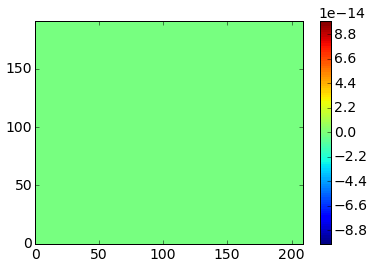

In [12]:
Depth, hfacc, dxF, dyF, X, Y, Z, nx, ny, k = grid(36)

Depth1 = np.zeros_like(Depth)
for xx in range(len(X)):
    for yy in range(len(Y)):
        #Depth1[yy,xx] = (xx - len(X)/2)**2 + (yy - len(Y)/2)**2
        Depth1[yy,xx] = np.abs(xx - len(X)/2)
Depth, hfacc, dxF, dyF, X, Y, Z, nx, ny, k = grid(36)
Sx2,Sy2 = grad_calc_mod(Depth1, hfacc, dxF, dyF, X, Y, Z, 36)
#plt.contourf(Depth1,100)
#plt.contourf(Sx2,100)
plt.contourf(Sy2,100)
plt.colorbar()


<matplotlib.colorbar.Colorbar instance at 0x2adbae14e440>

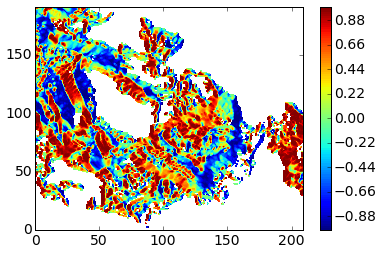

In [134]:
normalizer = np.sqrt(np.array(np.gradient(Depth))[1,:,:]**2 + np.array(np.gradient(Depth))[0,:,:]**2)

plt.contourf(np.array(np.gradient(Depth))[1,:,:]/normalizer,100)
plt.colorbar()

<matplotlib.colorbar.Colorbar instance at 0x2adbb0690f80>

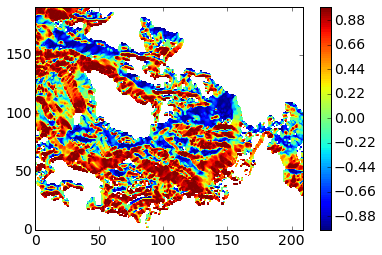

In [135]:
plt.contourf(np.array(np.gradient(Depth))[0,:,:]/normalizer,100)
plt.colorbar()

<matplotlib.colorbar.Colorbar instance at 0x2adb4b899e18>

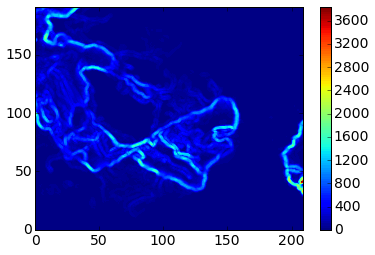

In [133]:
plt.contourf(np.sqrt(np.array(np.gradient(Depth))[1,:,:]**2 + np.array(np.gradient(Depth))[0,:,:]**2),100)
plt.colorbar()

In [149]:
S1 = np.array(S0)
S2 = np.array(S0)
S3 = np.array(S0)
S4 = np.array(S0)
S5 = np.array(S0)

nt = 100000
vel = 1
Sx2_touse = np.array(np.gradient(Depth))[0,:,:]*vel
Sy2_touse = np.array(np.gradient(Depth))[1,:,:]*vel

normalizer = np.sqrt(np.array(np.gradient(Depth))[1,:,:]**2 + np.array(np.gradient(Depth))[0,:,:]**2)

Sx2_norm = np.array(np.gradient(Depth))[0,:,:]/normalizer
Sy2_norm = np.array(np.gradient(Depth))[1,:,:]/normalizer

Sx2_norm[np.isnan(Sx2_norm)] = 0
Sy2_norm[np.isnan(Sy2_norm)] = 0

diff1 = np.zeros([nt,1])
diff2 = np.zeros([nt,1])
diff3 = np.zeros([nt,1])

S3_save = np.ndarray([nt/100,192,210])

Sx_comb = np.ndarray([192,210,210])
for x in range(S1.shape[0]):
    Sx_comb[x,:,:] = id_x*Sx2_touse[x,:]

for i in range(0,nt):
    #print U.shape,V.shape,id_x.shape,id_y.shape
    
    for x in range(S1.shape[0]):
        S1[x,:] = S1[x,:] + np.dot(id_x*Sx2_norm[x,:],S1[x,:])
        S3[x,:] = S3[x,:] + np.dot(id_x*Sx2_norm[x,:],S3[x,:])
    for y in range(S1.shape[1]):
        S2[:,y] = S2[:,y] + np.dot(id_y*Sy2_norm[:,y],S2[:,y]) 
        S3[:,y] = S3[:,y] + np.dot(id_y*Sy2_norm[:,y],S3[:,y]) 
    
    if i%100 == 0:
        S3_save[i/100,:,:] = S3
    if i%1000==0:
        print i

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000


<matplotlib.contour.QuadContourSet instance at 0x2adb3a258878>

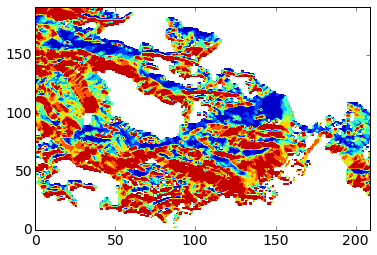

In [144]:
plt.contourf(Sx2_norm)

In [118]:
S3_time1 = np.array(S3_save)
S3_time1[:,hfacc[0,:,:]==0] = np.nan
print S3_time1.shape

(1000, 192, 210)


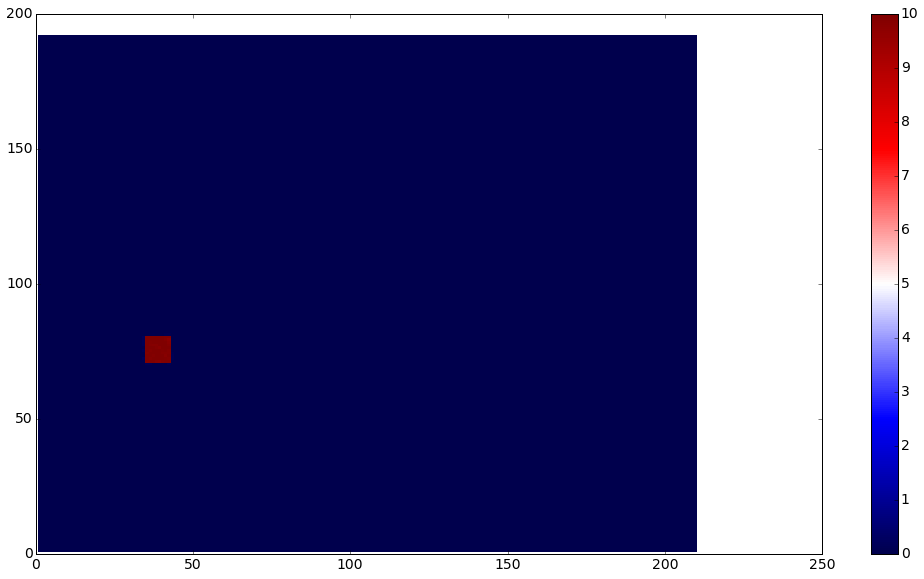

In [146]:
def interact(field,cmap1,vimin1,vimin2,vimax1,vimax2,time1,time2):
    def plot_field2(vimin=1,vimax=20,time=0,Z=0):
        # This function plots a 2D field, the field is meant to have NaNs on the land place                                                
        # vimin is the minimun, vimax is the maximum, setbad is the NaN color, unity is the unity in the colorbar                          
        # cmap is a colomap                                                                                                               
        fig,axes = plt.subplots(1,1)
        masked_array = np.ma.array(field[time*10,:,:], mask=np.isnan(field[time*10,:,:]))
        cmap= cmap1
        cmap.set_bad('black',1.)
        ca = plt.pcolor(X,Y,masked_array,vmin = vimin, vmax = vimax,cmap = cmap)
        cbar = fig.colorbar(ca )
        fig.subplots_adjust(right=2.4,top=2)
        return plot_field2
        
    w = interactive(plot_field2,vimin=(vimin1,vimin2),vimax=(vimax1,vimax2),time=(time1,time2),Z=(time1,time2))
    display(w)
interact(S3_save,matplotlib.cm.seismic,-10,10,0,100,0,100)

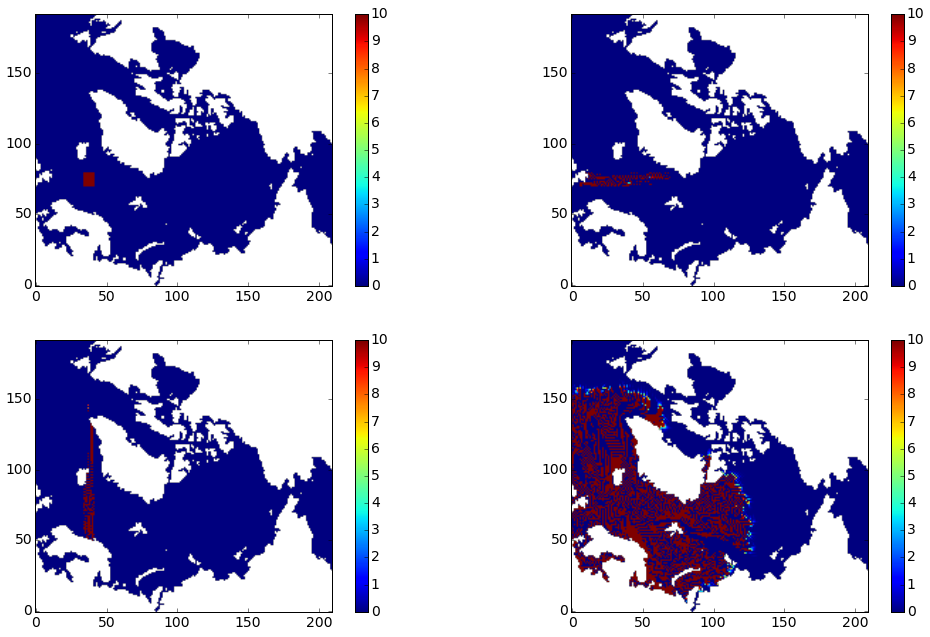

In [150]:
#S[hfacc[0,:,:]==0]=np.nan
S00 = np.array(S0)
#S00[hfacc[0,:,:]==0]=np.nan
vimin = 0
vimax = 10
fig, axes = plt.subplots(2,2)
S00[hfacc[0,:,:]==0]=np.nan
a0 = axes[0,0].imshow(S00,vmin=vimin,vmax=vimax,origin="lower")
cbar = fig.colorbar(a0 , ax=axes[0,0])
S1[hfacc[0,:,:]==0]=np.nan
a1 = axes[0,1].imshow(S1,vmin=vimin,vmax=vimax,origin="lower")
cbar = fig.colorbar(a1 , ax=axes[0,1])
S2[hfacc[0,:,:]==0]=np.nan
a2 = axes[1,0].imshow(S2,vmin=vimin,vmax=vimax,origin="lower")
cbar = fig.colorbar(a2 , ax=axes[1,0])
S3[hfacc[0,:,:]==0]=np.nan
a3 = axes[1,1].imshow(S3,vmin=vimin,vmax=vimax,origin="lower")
cbar = fig.colorbar(a3 , ax=axes[1,1])

fig.subplots_adjust(right=2.4,top=2.2)

In [6]:
def nangrid(field,res):
    ### This script fills the field with nans in the right bit
    if res == 18:
        x="/scratch/general/am8e13/results18km/"        
        nx = 420
        ny = 384 
    elif res == 36:
        x="/scratch/general/am8e13/results36km/"
        nx = 210
        ny = 192
    file2read = netcdf.NetCDFFile(x+"grid.nc",'r')
    hfacc = file2read.variables['HFacC']
    hfacc = hfacc[:]*1
    
    if len(field.shape) == 4 :
        field[:,hfacc == 0] = np.nan
    elif len(field.shape) == 3 :
        field[hfacc == 0] = np.nan
    elif len(field.shape) == 2 :
        field[hfacc[0,:,:] == 0] = np.nan
    
    return field

In [7]:
x="/scratch/general/am8e13/results18km/"        
file2read = netcdf.NetCDFFile(x+"grid.nc",'r')
hfacc = file2read.variables['HFacC']
hfacc = hfacc[:]*1

In [8]:
## 1 D version of the advection equation

In [156]:
dt = 0.00001
dx = 1

def S0(x):
    if x > 100
S_1d = np.zeros(200)
S_1d[40:60]=10
S_1d[90:110]=10
S_1d[140:160]=10
V_1d = np.zeros_like(S_1d)
for x in range(200):
    V_1d[x]= (x - 200/2)*10

V_1d[:] = -1000
    
id_1d = np.zeros((200, 200))
for j in range(0,198,1):
    id_1d[j+1,j] = dt/dx*V_1d[j+1]
    id_1d[j,j] = -dt/dx*V_1d[j]
id_1d[199,199]=-dt/dx*V_1d[j]


id_2o_1d = np.zeros((200, 200))
for j in range(1,198,1):
    id_2o_1d[j+1,j] = -dt/(2*dx)*V_1d[j+1]
    id_2o_1d[j-1,j] = dt/(2*dx)*V_1d[j-1]
    
id_2o_1d[0,0] = -dt/(2*dx)*V_1d[1]
id_2o_1d[1,0] = -dt/(2*dx)*V_1d[1]
id_2o_1d[197,198] = dt/(2*dx)*V_1d[197]
id_2o_1d[198,199] = dt/(2*dx)*V_1d[198]
id_2o_1d[199,198] = -dt/(2*dx)*V_1d[198]
id_2o_1d[199,199] = dt/(2*dx)*V_1d[198]
    
#id_2o_1d[:,0] = id_2o_1d[:,1] #-dt/(2*dx)*V_1d[2]
#id_2o_1d[0,:] = id_2o_1d[1,:] #-dt/(2*dx)*V_1d[2]
#id_2o_1d[:,199] = id_2o_1d[:,198] #dt/(2*dx)*V_1d[j-1]
#id_2o_1d[199,:] = id_2o_1d[198,:]

diff = np.zeros_like(id_1d)
err = 10
for j in range(1,198,1):
    diff[j+1,j] = dt/(2*dx)*err
    diff[j-1,j] = dt/(2*dx)*err
    #diff[j,j] = -dt/(dx)*err
    
# Timesteps
ts = 10000
Stime = np.zeros((200,ts))
Stime[:,0]=S_1d
for t in range(1,ts,1):
    if t > ts/3:
        jj = 1
    else :
        jj = 1
        
    adv = np.dot(jj*id_2o_1d,Stime[:,t-1])
    adv[0] = 0
    adv[1] = 0
    adv[199] = 0
    adv[198] = 0
    Stime[:,t] = adv + Stime[:,t-1] #+ np.sum(diff,axis=1)
    
Stime_sol = np.zeros_like(Stime)
for t in range(1,ts,1):
    for x in range(len(V_1d)):
        Stime_sol[x,t] = x*dx + V_1d[x]*t*dt
        

                   
#plt.contourf(Stime)
plt.imshow(Stime_sol,aspect='auto',vmin=-15,vmax=15)
plt.colorbar()

SyntaxError: invalid syntax (<ipython-input-156-2c2b36991040>, line 5)

In [252]:
!cd /noc/users/am8e13/Python/sfepy/
!python ../sfepy/postproc.py square_tri2.*.vtk -b --wireframe

Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 30 days
postproc.py: cannot connect to X server localhost:17.0


In [250]:
!pwd

/noc/users/am8e13/Python/notebooks
